In [ ]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

from multiple_shooting import setup_multiple_shooting
from cnlls_solver import solve_cnlls_ipopt, solve_cnlls_gauss_newton, solve_cnlls_gauss_newton_logparam
from notorious import make_notorious_integrator, get_initial_state, get_true_parameters, simulate_notorious_measurements
from utils import add_noise, evaluate_fit


CasADi - 2025-05-23 01:33:22 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:698]



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      224
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      146

Total number of variables............................:       59
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       56
Total number of inequality c

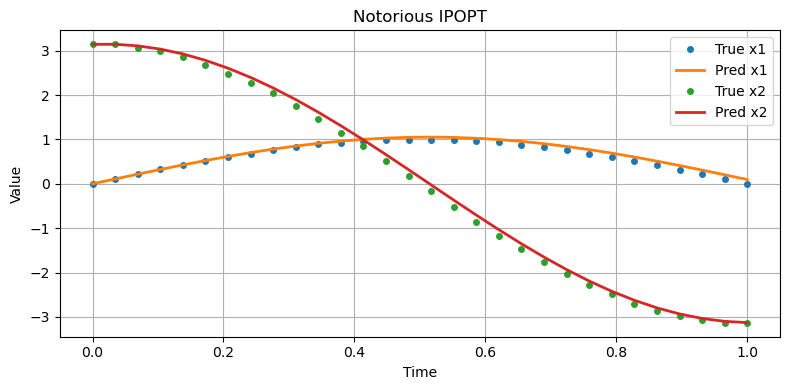

[Notorious GN] x1 Errors:
  RMSE = 0.1231
  MAE  = 0.0967
  R2   = 0.8547
[Notorious GN] x2 Errors:
  RMSE = 0.2492
  MAE  = 0.2263
  R2   = 0.9878


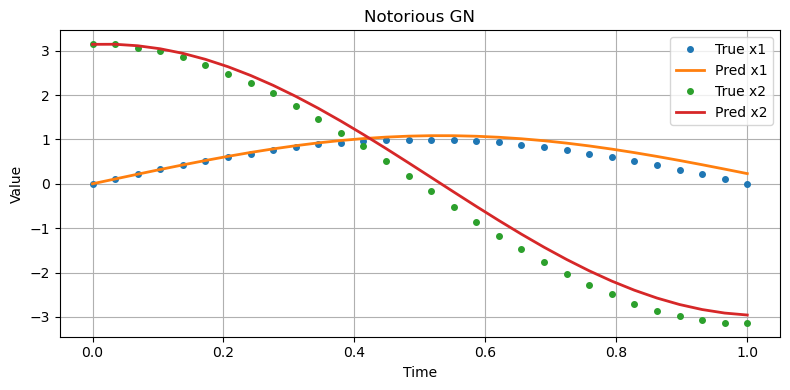

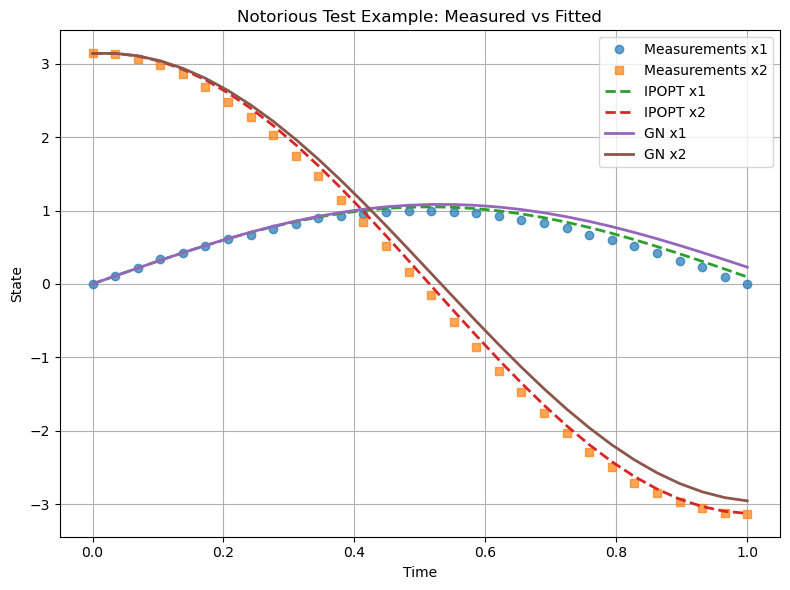

In [2]:
def setup_notorious_shooting(t_grid, nx, np_p, mu):
    """
    Special shooting setup for Notorious example with dynamic t injection per interval.
    """
    N = len(t_grid) - 1
    dt_list = np.diff(t_grid)

    S_vars = [ca.MX.sym(f's_{i}', nx) for i in range(N)]
    P_var = ca.MX.sym('p', np_p)
    w = ca.vertcat(*S_vars, P_var)

    X_end = []
    g_constr = []

    for j in range(N):
        integrator = make_notorious_integrator(dt_list[j], mu)
        t_j = t_grid[j]
        res = integrator(x0=S_vars[j], p=ca.vertcat(P_var, t_j))
        x_end = res['xf']
        X_end.append(x_end)
        if j + 1 < N:
            g_constr.append(x_end - S_vars[j + 1])

    g = ca.vertcat(*g_constr)
    return w, X_end, g, S_vars, P_var


def notorious_simulate_with_integrator(p_est, mu, t_grid):
    dts = np.diff(t_grid)
    integrators = [make_notorious_integrator(dt, mu) for dt in dts]
    x = np.array([0.0, np.pi])
    result = [x]
    for j in range(len(dts)):
        t_j = t_grid[j]
        x = integrators[j](x0=x, p=np.array([p_est[0], t_j]))['xf'].full().flatten()
        result.append(x)
    return np.array(result)


# ------------------ Main Workflow ------------------

mu = 1.0
p_true_not = get_true_parameters()
x0_not = get_initial_state()
t_grid_not = np.linspace(0, 1, 30)  # 0.0, 0.1, ..., 1.0
N_not = len(t_grid_not) - 1
nx_not = 2
np_not = 1

# Noisy measurements
y_meas_not = simulate_notorious_measurements(mu, p_true_not, t_grid_not, noise_level=0.01)
y_meas_not[0, :] = [0.0, np.pi]

# Multiple shooting setup (dynamic t_j injection)
w_not, X_end_not, g_not, S_vars_not, P_var_not = setup_notorious_shooting(
    t_grid_not, nx_not, np_not, mu
)

# Residuals (x(t_{j+1}) - y_meas[j+1])
F1_not = ca.vertcat(*[X_end_not[i] - y_meas_not[i + 1] for i in range(N_not)])

# Initial guess
w0_not = np.concatenate([y_meas_not[:-1].reshape(-1), [3.1]])

# IPOPT solve
sol_ipopt_not = solve_cnlls_ipopt(w=w_not, F1=F1_not, g=g_not, w0=w0_not)
w_opt_ipopt_not = sol_ipopt_not['x']
p_est_ipopt_not = w_opt_ipopt_not[-np_not:]
print("[Notorious][IPOPT] estimated parameter:", p_est_ipopt_not)

# GN solve
sol_gn_not = solve_cnlls_gauss_newton_logparam(
    w=w_not, F1=F1_not, g=g_not, w0=w0_not, n_params=np_not
)
w_opt_gn_not = sol_gn_not['x']
p_est_gn_not = w_opt_gn_not[-np_not:]
print("[Notorious][GN] estimated parameter:", p_est_gn_not)

# Simulated trajectories
y_est_ipopt_not = notorious_simulate_with_integrator(p_est_ipopt_not, mu, t_grid_not)
y_est_gn_not = notorious_simulate_with_integrator(p_est_gn_not, mu, t_grid_not)

# Evaluate fit
evaluate_fit(y_meas_not, y_est_ipopt_not, t_grid_not, label="Notorious IPOPT", species_names=["x1", "x2"])
evaluate_fit(y_meas_not, y_est_gn_not, t_grid_not, label="Notorious GN", species_names=["x1", "x2"])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(t_grid_not, y_meas_not[:, 0], 'o', label='Measurements x1', alpha=0.7)
plt.plot(t_grid_not, y_meas_not[:, 1], 's', label='Measurements x2', alpha=0.7)
plt.plot(t_grid_not, y_est_ipopt_not[:, 0], '--', label='IPOPT x1', linewidth=2)
plt.plot(t_grid_not, y_est_ipopt_not[:, 1], '--', label='IPOPT x2', linewidth=2)
plt.plot(t_grid_not, y_est_gn_not[:, 0], '-', label='GN x1', linewidth=2)
plt.plot(t_grid_not, y_est_gn_not[:, 1], '-', label='GN x2', linewidth=2)
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Notorious Test Example: Measured vs Fitted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()